In [1]:
# Created or modified on Sep 2022
# author: 임일
# KNN CF

import numpy as np
import pandas as pd

In [2]:
# csv 파일에서 불러오기
ratings = pd.read_csv('C:/RecoSys/Data/EM_ratings.csv', encoding='utf-8')

In [3]:
# Rating 데이터를 test, train으로 나누고 train을 full matrix로 변환
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=12)
rating_matrix = x_train.pivot(values='rating', index='user_id', columns='movie_id')

In [4]:
# Train set의 모든 사용자 pair의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)


In [5]:
# RMSE 계산을 위한 함수
def RMSE(y_true, y_pred):
    import numpy as np
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

def score(model, k=20):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie, k) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

In [15]:
# Neighbor size를 고려하는 추천
def cf_knn(user_id, movie_id, neighbor_size=20):

    mean_rating = 3.0

    if movie_id in rating_matrix:

        # 현재 사용자와 다른 사용자 간의 similarity 가져오기
        sim_scores = user_similarity[user_id]
        # 현재 영화에 대한 모든 사용자의 rating값 가져오기
        movie_ratings = rating_matrix[movie_id]
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.drop(none_rating_idx)
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)

        if neighbor_size == 0:               # Neighbor size가 지정되지 않은 경우
            # 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
            mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
        else:                                # Neighbor size가 지정된 경우
            # 지정된 neighbor size 값과 해당 영화를 평가한 총사용자 수 중 작은 것으로 결정
            neighbor_size = min(neighbor_size, len(sim_scores))
            # array로 바꾸기 (argsort를 사용하기 위함)
            sim_scores = np.array(sim_scores)
            movie_ratings = np.array(movie_ratings)
            # 유사도를 순서대로 정렬
            user_idx = np.argsort(sim_scores)
            # 유사도를 neighbor size만큼 받기
            # 오름차순으로 정렬했기 때문에 -@ 해야 유사도가 큰 사람을 고를 수 있음
            sim_scores = sim_scores[user_idx][-neighbor_size:]  
            # 영화 rating을 neighbor size만큼 받기
            movie_ratings = movie_ratings[user_idx][-neighbor_size:]
            # 최종 예측값 계산 
            if sim_scores.sum() > 0 :
                mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()

    return mean_rating

score(cf_knn, 60)

0.942818894526895

#### 추천하기

In [11]:
# 추천을 위한 데이터 읽기 (추천을 위해서는 전체 데이터를 읽어야 함)
ratings = pd.read_csv('C:/RecoSys/Data/EM_ratings.csv', encoding='utf-8')
rating_matrix = ratings.pivot(values='rating', index='user_id', columns='movie_id')

movies = pd.read_csv('C:/RecoSys/Data/movie.csv', encoding='utf-8')
movies = movies[['ID', 'Name']]
movies.columns = ['movie_id', 'title']
movies = movies.set_index('movie_id')

In [12]:
# Cosine similarity 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

In [13]:
# 추천하기
def recommender(user, n_items=10, neighbor_size=20):
    # 현재 사용자의 모든 아이템에 대한 예상 평점 계산
    predictions = []
    rated_index = rating_matrix.loc[user][rating_matrix.loc[user] > 0].index    # 이미 평가한 영화 확인
    items = rating_matrix.loc[user].drop(rated_index)
    for item in items.index:
        predictions.append(cf_knn(user, item, neighbor_size))                   # 예상평점 계산
    recommendations = pd.Series(data=predictions, index=items.index, dtype=float)
    recommendations = recommendations.sort_values(ascending=False)[:n_items]    # 예상평점이 가장 높은 영화 선택
    recommended_items = movies.loc[recommendations.index]['title']
    return recommended_items

In [16]:
# 영화 추천 함수 부르기
recommender(5, 10, 60)

movie_id
1648                              The Game (1997)
668     Pather Panchali (Song of the Road) (1955)
142                                Shadows (1988)
1351                               Blood and Wine
1567            The Last Time I Committed Suicide
1572                          Contempt (Le M?ris)
1123                          A Perfect Candidate
1109    Charms Zwischenfaelle (Charm's Incidents)
526              Savage Nights (Les Nuits fauves)
947                         My Man Godfrey (1936)
Name: title, dtype: object

#### optimal size 구하기

[0.8774748095492629, 0.9077764781324855, 0.9281268805388616, 0.942818894526895, 0.9536426305780575, 0.9620266151713536, 0.968925279251072]


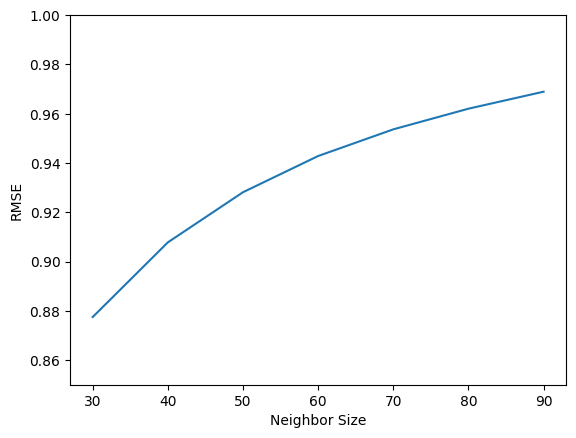

In [19]:
RMSE_by_K = []
Neighbor_size = []
for K in range(30, 100, 10):
    RMSE_by_K.append(score(cf_knn, K))
    Neighbor_size.append(K)
print(RMSE_by_K)

# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(Neighbor_size, RMSE_by_K)
plt.ylim(0.85, 1.0)
plt.xlabel('Neighbor Size')
plt.ylabel('RMSE')
plt.show()